In [1]:
!pip install -q sentence-transformers faiss-cpu umap-learn scikit-learn pandas tqdm matplotlib ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.1 MB/s eta 0:00:00


Loaded rows: 4467
Sample search_text: The intangible effects of walls. More barriers exist now than at the end of World War II, says designer Alexandra Auer. And when you erect one wall, you unwittingly create a second -- an "us" versus "
Loading model all-MiniLM-L6-v2...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Embeddings shape: (4467, 384)
Index ntotal: 4467
Saved index + embeddings to /content/ted_index


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Recall@1 (title-as-query): 0.9543, Recall@5: 0.9893


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


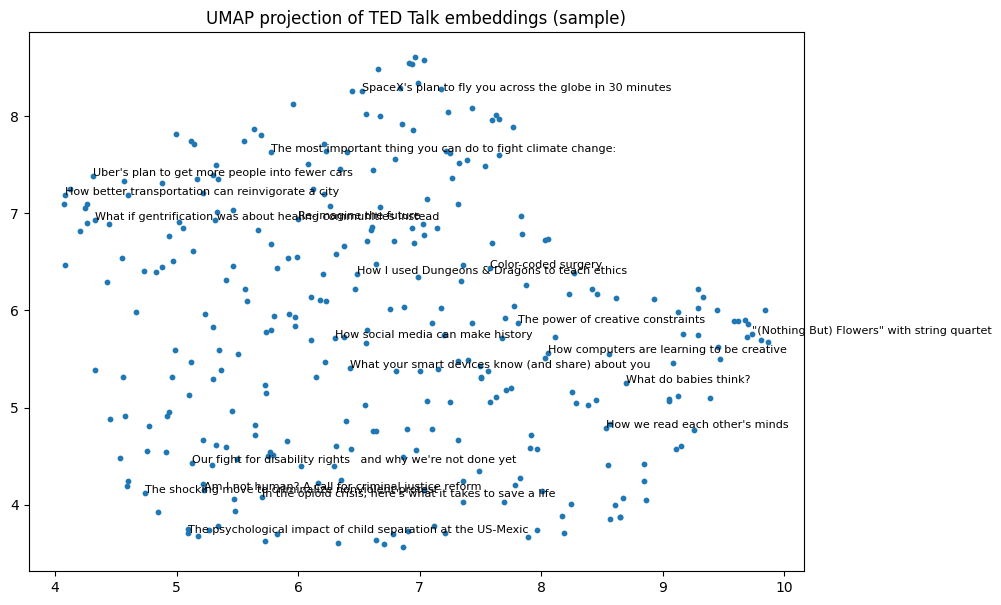


Workflow done. Use interactive_search(...) to try queries in the notebook.


In [4]:
import os
import math
import re
import random
from typing import List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

from sentence_transformers import SentenceTransformer

import faiss

from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    return text


def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    for c in ['title', 'details', 'speaker', 'url']:
        if c not in df.columns:
            df[c] = ""
    df = df.reset_index(drop=True)
    df['title'] = df['title'].fillna("").astype(str).apply(clean_text)
    df['details'] = df['details'].fillna("").astype(str).apply(clean_text)
    df['speaker'] = df['speaker'].fillna("").astype(str).apply(clean_text)
    df['search_text'] = (df['title'] + '. ' + df['details'] + ' Speaker: ' + df['speaker']).str[:25000]
    if 'id' not in df.columns:
        df['id'] = df.index.astype(str)
    return df

class Embedder:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', device: str = None):
        print(f"Loading model {model_name}...")
        self.model = SentenceTransformer(model_name)

    def embed(self, texts: List[str], batch_size: int = 64) -> np.ndarray:
        embs = self.model.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
        faiss.normalize_L2(embs)
        return embs

def build_faiss_index(embs: np.ndarray) -> faiss.IndexFlatIP:
    d = embs.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embs)
    return index

def save_index_and_embeddings(index: faiss.IndexFlatIP, embs: np.ndarray, df: pd.DataFrame, out_dir: str = '/content/ted_index'):
    os.makedirs(out_dir, exist_ok=True)
    faiss.write_index(index, os.path.join(out_dir, 'faiss_index.bin'))
    np.save(os.path.join(out_dir, 'embeddings.npy'), embs)
    df.to_csv(os.path.join(out_dir, 'ted_processed.csv'), index=False)
    print(f"Saved index + embeddings to {out_dir}")


def load_index_and_embeddings(in_dir: str = '/content/ted_index') -> Tuple[faiss.IndexFlatIP, np.ndarray, pd.DataFrame]:
    idx = faiss.read_index(os.path.join(in_dir, 'faiss_index.bin'))
    embs = np.load(os.path.join(in_dir, 'embeddings.npy'))
    df = pd.read_csv(os.path.join(in_dir, 'ted_processed.csv'))
    return idx, embs, df

def query_index(index: faiss.IndexFlatIP, embedder: Embedder, query: str, top_k: int = 10, fetch_k: int = 50):
    q_emb = embedder.embed([query])
    fetch_k = min(fetch_k, index.ntotal)
    D, I = index.search(q_emb, fetch_k)
    return D[0], I[0]


def mmr(doc_embs: np.ndarray, query_emb: np.ndarray, fetch_indices: List[int], k: int = 10, lambda_param: float = 0.7):
    sub_embs = doc_embs[fetch_indices]
    sims = (sub_embs @ query_emb.reshape(-1, 1)).squeeze()
    selected = []
    selected_idx = []
    if len(sims) == 0:
        return []
    first = int(np.argmax(sims))
    selected.append(fetch_indices[first])
    selected_idx.append(first)
    candidates = list(range(len(sims)))
    candidates.remove(first)
    while len(selected) < k and candidates:
        mmr_scores = []
        for c in candidates:
            relevance = sims[c]
            diversity = 0.0
            for s in selected_idx:
                sim_s = sub_embs[c] @ sub_embs[s]
                if sim_s > diversity:
                    diversity = sim_s
            score = lambda_param * relevance - (1 - lambda_param) * diversity
            mmr_scores.append(score)
        next_rel = candidates[int(np.argmax(mmr_scores))]
        selected.append(fetch_indices[next_rel])
        selected_idx.append(next_rel)
        candidates.remove(next_rel)
    return selected


def recall_at_k_using_titles(df: pd.DataFrame, embs: np.ndarray, index: faiss.IndexFlatIP, embedder: Embedder, k: int = 5):
    hits = 0
    n = len(df)
    all_q_embs = embedder.embed(df['title'].tolist())
    D, I = index.search(all_q_embs, k)
    hits = sum(i in I[row_idx] for row_idx, i in enumerate(range(len(df))))
    recall = hits / len(df)

    return recall


def visualize_embeddings(embs: np.ndarray, df: pd.DataFrame, n_points: int = 200, seed: int = 42):
    rng = np.random.RandomState(seed)
    n = embs.shape[0]
    if n_points < n:
        idxs = rng.choice(n, n_points, replace=False)
    else:
        idxs = np.arange(n)
    sub_embs = embs[idxs]
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=seed)
    coords = reducer.fit_transform(sub_embs)
    plt.figure(figsize=(10, 7))
    plt.scatter(coords[:, 0], coords[:, 1], s=10)
    for i, pt in enumerate(idxs[:20]):
        plt.text(coords[i, 0], coords[i, 1], df['title'].iloc[pt][:60], fontsize=8)
    plt.title('UMAP projection of TED Talk embeddings (sample)')
    plt.show()


def interactive_search(index: faiss.IndexFlatIP, embs: np.ndarray, df: pd.DataFrame, embedder: Embedder, use_mmr: bool = True):
    while True:
        q = input('\nType a query (or `:quit` to exit): ').strip()
        if not q:
            print('empty — try again')
            continue
        if q.lower() in (':quit', 'quit', 'exit'):
            break
        D, I = query_index(index, embedder, q, top_k=10, fetch_k=50)
        if use_mmr:
            q_emb = embedder.embed([q]).squeeze()
            selected = mmr(embs, q_emb, I.tolist(), k=10)
            print('\nTop recommendations (MMR re-ranked):')
            for rank, idx in enumerate(selected, 1):
                row = df.iloc[idx]
                print(f"{rank}. {row['title']} — {row['speaker']} (idx={idx})")
                print('   ', row['url'])
                print('   ', row['details'][:300].replace('\n',' '))
        else:
            print('\nTop recommendations:')
            for rank, idx in enumerate(I[:10], 1):
                row = df.iloc[idx]
                print(f"{rank}. {row['title']} — {row['speaker']} (idx={idx})")
                print('   ', row['url'])
                print('   ', row['details'][:300].replace('\n',' '))


def main_workflow(
    csv_path: str = None,
    model_name: str = 'all-MiniLM-L6-v2',
    save_dir: str = '/content/ted_index',
    use_drive: bool = False
):

    df = pd.read_csv(csv_path)

    print('Loaded rows:', len(df))

    df = prepare_dataframe(df)
    print('Sample search_text:', df['search_text'].iloc[0][:200])

    embedder = Embedder(model_name=model_name)
    texts = df['search_text'].tolist()
    embs = embedder.embed(texts, batch_size=128)
    print('Embeddings shape:', embs.shape)

    index = build_faiss_index(embs)
    print('Index ntotal:', index.ntotal)

    save_index_and_embeddings(index, embs, df, out_dir=save_dir)

    r1 = recall_at_k_using_titles(df, embs, index, embedder, k=1)
    r5 = recall_at_k_using_titles(df, embs, index, embedder, k=5)
    print(f'Recall@1 (title-as-query): {r1:.4f}, Recall@5: {r5:.4f}')

    visualize_embeddings(embs, df, n_points=300)

    print('\nWorkflow done. Use interactive_search(...) to try queries in the notebook.')

main_workflow(csv_path='/content/tedx_datase.csv', model_name='all-MiniLM-L6-v2')

In [17]:
index, embs, df = load_index_and_embeddings('/content/ted_index')
embedder = Embedder(model_name='all-MiniLM-L6-v2')

query = "cleanliness"
D, I = query_index(index, embedder, query, top_k=10)

print(f"\nTop recommendations for: {query}\n")
for rank, idx in enumerate(I[:5], 1):
    row = df.iloc[idx]
    print(f"{rank}. {row['title']} — {row['main_speaker']}")
    print("   ", row['url'])
    print("   ", row['details'][:200].replace("\n"," "), "\n")


Loading model all-MiniLM-L6-v2...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Top recommendations for: cleanliness

1. Sanitation is a basic human right — Francis de los Reyes
    https://www.ted.com/talks/francis_de_los_reyes_sanitation_is_a_basic_human_right

2. What I discovered in New York City trash — Robin Nagle
    https://www.ted.com/talks/robin_nagle_what_i_discovered_in_new_york_city_trash
    New York City residents produce 11,000 tons of garbage every day. Every day! This astonishing statistic is just one of the reasons Robin Nagle started a research project with the city's Department of  

3. Better toilets, better life — Joe Madiath
    https://www.ted.com/talks/joe_madiath_better_toilets_better_life
    In rural India, the lack of toilets creates a big, stinking problem. It leads to poor quality water, one of the leading causes of disease in India, and has a disproportionately negative effect on wome 

4. Let's talk crap. Seriously. — Rose George
    https://www.ted.com/talks/rose_george_let_s_talk_crap_seriously
    It's 2013, yet 2.5 billion pe